In [1]:
import zipfile
 
try:
    with zipfile.ZipFile("animal+utils.zip") as zf:
        zf.extractall()
        print("uncompress success")
 
except:
    print("uncompress fail")



uncompress fail


# 1. Settings
## 1) Important requiered libraries

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt


In [43]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Saving utils.py to utils (2).py


## 2) Hyperparameter

In [44]:
batch_size = 16 #64  #1
learning_rate = 0.0001
epoch = 20

n_node = 1024 # customized last layer 의 노드 수, 64, 128, 256, 512, 1024
dropratio = 0.5 # 얼마나 드랍시킬지 inverse keepratio

imgsize = 256

# 2. Data Loader
## 트레이닝 데이터

In [45]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [83]:
#img_dir = "../../../images/painging_dataset/real_artwork_divided_shffl_4K/Valid"
img_dir = '/content/gdrive/My Drive/Colab Notebooks/animal/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            # ①(512)③②RCrop  <--- Best !!
            transforms.CenterCrop(imgsize*2),   # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),     # ② RandomCrop
            transforms.RandomHorizontalFlip(),  # ③ RandomHorizontalFlip
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)


46


In [84]:
# 2. Dev data
#img_dir = "../../../images/painging_dataset/real_artwork_divided_shffl_4K/Valid"
img_dir = '/content/gdrive/My Drive/Colab Notebooks/animal/val'
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256)
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))

dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

# 3. Test data
img_dir = '/content/gdrive/My Drive/Colab Notebooks/animal/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256)
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))

test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

nclass = len(train_data.classes)
print ("# of classes: %d" %nclass)
print (train_data.classes)
print (train_data.class_to_idx)
print (train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# for img, labels in train_batch:
#     for j in range(len(img)):
#         img = transforms.ToPILImage()(img[j])
#         plt.title("label: %d" %labels[j])
#         plt.imshow(img)
#         plt.show()


# of classes: 2
['cats', 'dogs']
{'cats': 0, 'dogs': 1}
46
Training: 46, Dev: 17, Test: 41


(None,)

In [85]:
# '.ipynb_checkpoints' 가 클래스로 나오는 경우, 새로운 폴더(train, val, test) 를 만들어 이동 시킬 것
print (train_data.classes)
print (dev_data.classes)
print (test_data.classes)

['cats', 'dogs']
['cats', 'dogs']
['cats', 'dogs']


# 3. Model
## 1) Pretrained VGG Model

In [86]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

#cnt = 0
#for i in model.children():
#    print("yhk[%d]" %cnt),
#    print(i)
#    cnt = cnt+1


features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [87]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## 2) Customized Fully Model

In [88]:
base_dim = 64
fsize = imgsize//32

class MyVGG(nn.Module):  
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize *fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), # 0.3 만큼 drop 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data) # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data) 
                m.bias.data.fill_(0)        
    def forward(self, x):
        #layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        #print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

## 3) Model on GPU

In [89]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False

for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [90]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [91]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# 5. Train

In [92]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train==False):
    #netname = './nets/media_vgg19_fixed.pkl'
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/catdog_vgg19_10.pkl'
    model  = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/catdog_vgg19'
    
    #grapgh 그리기
    x_epoch = []
    y_train_err =[]
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     #학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0,parameters():
#         params.required_grad = False
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):

    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if(i%disp_step == 0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            #evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            model.eval()
            
            # train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
                 %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            #graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 47.83, dev: 41.18, test: 48.78
0..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MyVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[0/20] loss: 0.971, 
Correct of train: 63.04, dev: 70.59, test: 58.54, 
time: 1.10 sec..
Total time: 1.10 sec
1..
Total time: 2.20 sec
2..
Total time: 3.45 sec
3..
Total time: 4.70 sec
4..
Total time: 5.96 sec
5..
Total time: 7.19 sec
6..
Total time: 8.46 sec
7..
Total time: 9.73 sec
8..
Total time: 10.97 sec
9..
Total time: 12.22 sec
10..

[10/20] loss: 0.278, 
Correct of train: 95.65, dev: 76.47, test: 100.00, 
time: 13.48 sec..
Total time: 13.48 sec
11..
Total time: 14.60 sec
12..
Total time: 15.86 sec
13..
Total time: 17.11 sec
14..
Total time: 18.37 sec
15..
Total time: 19.63 sec
16..
Total time: 20.88 sec
17..
Total time: 22.15 sec
18..
Total time: 23.41 sec
19..

[19/20] loss: 0.155, 
Correct of train: 97.83, dev: 76.47, test: 100.00, 
time: 24.66 sec..
Total time: 24.66 sec


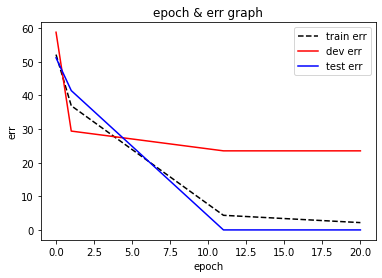

In [93]:
# epoch-err curve
if(to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

# 6. Evaluation for dev & test data

Normalized confusion matrix


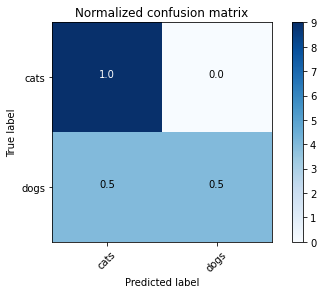

Confusion matrix, without normalization


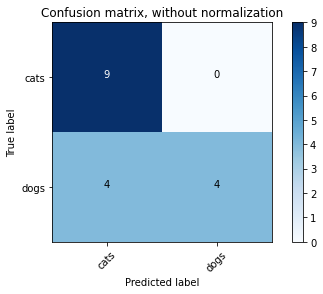

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.76 |	 0.69 |	 1.00 |	 0.82
 dogs: 0.76 |	 1.00 |	 0.50 |	 0.67
*accuracy: 0.76, precision: 0.85, recall: 0.75, *f1 score: 0.74
[AP]
cats: 0.93
dogs: 0.91

[mAP] 0.918
[miAP] 0.882


(array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]),
 array([0.66407943, 0.59444183, 0.87287891, 0.73502821, 0.99684936,
        0.99573195, 0.99902564, 0.79811221, 0.85416228, 0.81620651,
        0.58535469, 0.61646491, 0.99972016, 0.93512815, 0.99795491,
        0.97402257, 0.79656142]))

In [94]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


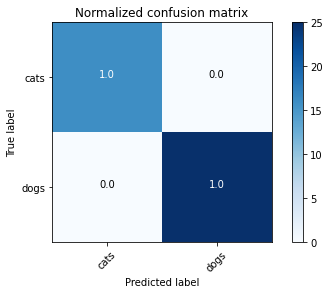

Confusion matrix, without normalization


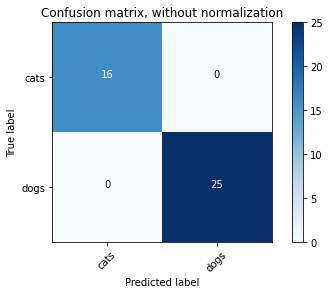

	 acc  |	 pre  |	 rec  |	 f1
 cats: 1.00 |	 1.00 |	 1.00 |	 1.00
 dogs: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
cats: 1.00
dogs: 1.00

[mAP] 1.000
[miAP] 1.000


(array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]),
 array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]),
 array([0.97530603, 0.98931205, 0.99228019, 0.99395889, 0.81628597,
        0.88264877, 0.99754113, 0.95409465, 0.83724904, 0.89510751,
        0.99959075, 0.99701148, 0.99047941, 0.97450936, 0.98827356,
        0.99061924, 0.9786638 , 0.99701148, 0.99999452, 0.93303049,
        0.98751831, 0.92606604, 0.99992126, 0.99345553, 0.92258668,
        0.99061924, 0.97512424, 0.97116113, 0.96306014, 0.99991745,
        0.99409479, 0.90298045, 0.99947548, 0.9260664 , 0.97917449,
        0.95860869, 0.99483436, 0.77611047, 0.78509557, 0.98561078,
        0.99472356]))

In [95]:
model.eval()
utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: cats
 True predicted images/total cats category: 9 / 9
Predicted probability:
[0.93512815 0.06487185]


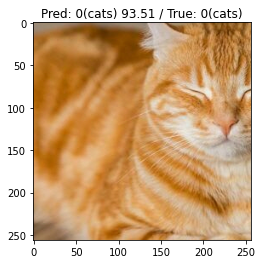

Predicted probability:
[0.6640794 0.3359206]


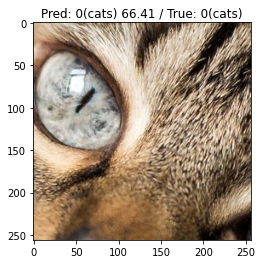

 False predicted images/total cats category: 0 / 9
Category: dogs
 True predicted images/total dogs category: 4 / 8
Predicted probability:
[0.12712106 0.8728789 ]


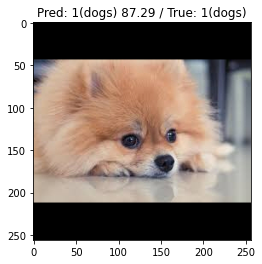

Predicted probability:
[2.7982800e-04 9.9972016e-01]


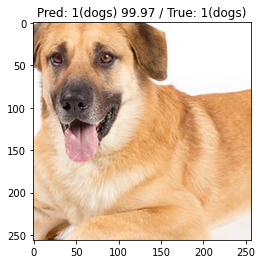

 False predicted images/total dogs category: 4 / 8
Predicted probability:
[0.7965615  0.20343849]


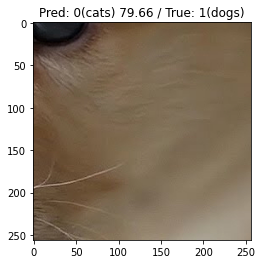

Predicted probability:
[0.7981122  0.20188776]


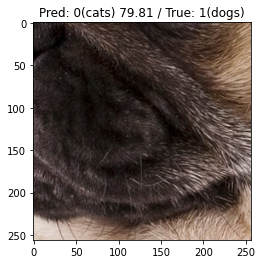

In [96]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)

# 나만의 커스텀 테이터 셋

## Data Loader
###  트레이닝 데이터

In [97]:
#img_dir = "../../../images/painging_dataset/real_artwork_divided_shffl_4K/Valid"
img_dir = '/content/gdrive/My Drive/Colab Notebooks/car/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            # ①(512)③②RCrop  <--- Best !!
            transforms.CenterCrop(imgsize*2),   # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),     # ② RandomCrop
            transforms.RandomHorizontalFlip(),  # ③ RandomHorizontalFlip
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)


20


### 고정된 데이터 셋

In [98]:
# 2. Dev data
#img_dir = "../../../images/painging_dataset/real_artwork_divided_shffl_4K/Valid"
img_dir = '/content/gdrive/My Drive/Colab Notebooks/car/val'
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256)
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))

dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

# 3. Test data
img_dir = '/content/gdrive/My Drive/Colab Notebooks/car/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256)
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))

test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

nclass = len(train_data.classes)
print ("# of classes: %d" %nclass)
print (train_data.classes)
print (train_data.class_to_idx)
print (train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# for img, labels in train_batch:
#     for j in range(len(img)):
#         img = transforms.ToPILImage()(img[j])
#         plt.title("label: %d" %labels[j])
#         plt.imshow(img)
#         plt.show()


# of classes: 2
['sedan', 'truck']
{'sedan': 0, 'truck': 1}
20
Training: 20, Dev: 20, Test: 20


(None,)

In [99]:
# '.ipynb_checkpoints' 가 클래스로 나오는 경우, 새로운 폴더(train, val, test) 를 만들어 이동 시킬 것
print (train_data.classes)
print (dev_data.classes)
print (test_data.classes)

['sedan', 'truck']
['sedan', 'truck']
['sedan', 'truck']


##  Model
### 1) Pretrained VGG Model

In [100]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

#cnt = 0
#for i in model.children():
#    print("yhk[%d]" %cnt),
#    print(i)
#    cnt = cnt+1


features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [101]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 2) Customized Fully Model

In [102]:
base_dim = 64
fsize = imgsize//32

class MyVGG(nn.Module):  
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize *fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), # 0.3 만큼 drop 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data) # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data) 
                m.bias.data.fill_(0)        
    def forward(self, x):
        #layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        #print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [103]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False

for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [104]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [105]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

## 5. Train

In [106]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train==False):
    #netname = './nets/media_vgg19_fixed.pkl'
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/sedantruck_vgg19_10.pkl'
    model  = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/sedantruck_vgg19'
    
    #grapgh 그리기
    x_epoch = []
    y_train_err =[]
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     #학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0,parameters():
#         params.required_grad = False
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):

    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if(i%disp_step == 0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            #evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            model.eval()
            
            # train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
                 %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            #graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 65.00, dev: 50.00, test: 25.00
0..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MyVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[0/20] loss: 1.569, 
Correct of train: 60.00, dev: 40.00, test: 35.00, 
time: 0.75 sec..
Total time: 0.75 sec
1..
Total time: 1.51 sec
2..
Total time: 2.27 sec
3..
Total time: 3.05 sec
4..
Total time: 3.80 sec
5..
Total time: 4.56 sec
6..
Total time: 5.38 sec
7..
Total time: 6.15 sec
8..
Total time: 6.91 sec
9..
Total time: 7.66 sec
10..

[10/20] loss: 0.823, 
Correct of train: 95.00, dev: 95.00, test: 70.00, 
time: 8.41 sec..
Total time: 8.41 sec
11..
Total time: 9.17 sec
12..
Total time: 9.93 sec
13..
Total time: 10.71 sec
14..
Total time: 11.48 sec
15..
Total time: 12.23 sec
16..
Total time: 13.00 sec
17..
Total time: 13.77 sec
18..
Total time: 14.54 sec
19..

[19/20] loss: 0.208, 
Correct of train: 100.00, dev: 95.00, test: 85.00, 
time: 15.29 sec..
Total time: 15.29 sec


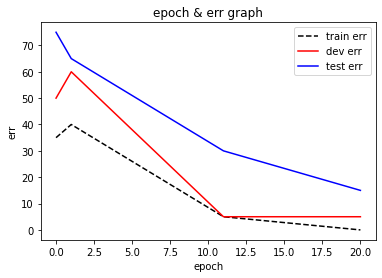

In [107]:
# epoch-err curve
if(to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


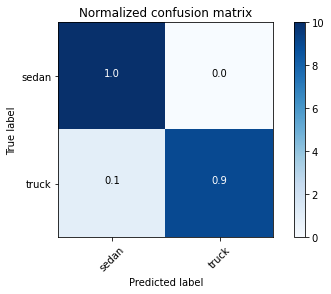

Confusion matrix, without normalization


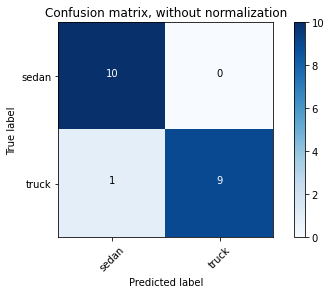

	 acc  |	 pre  |	 rec  |	 f1
 sedan: 0.95 |	 0.91 |	 1.00 |	 0.95
 truck: 0.95 |	 1.00 |	 0.90 |	 0.95
*accuracy: 0.95, precision: 0.95, recall: 0.95, *f1 score: 0.95
[AP]
sedan: 1.00
truck: 1.00

[mAP] 1.000
[miAP] 0.975


(array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]),
 array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]),
 array([0.93361455, 0.86558008, 0.80650771, 0.70642495, 0.57478905,
        0.80059832, 0.66006207, 0.88297689, 0.90087497, 0.80744559,
        0.69161105, 0.82387018, 0.88197398, 0.73681593, 0.69346392,
        0.91144568, 0.5896666 , 0.62473583, 0.57235241, 0.60401177]))

In [108]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


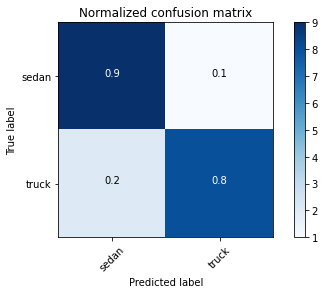

Confusion matrix, without normalization


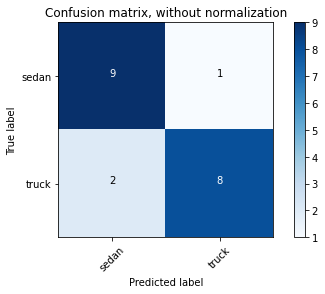

	 acc  |	 pre  |	 rec  |	 f1
 sedan: 0.85 |	 0.82 |	 0.90 |	 0.86
 truck: 0.85 |	 0.89 |	 0.80 |	 0.84
*accuracy: 0.85, precision: 0.85, recall: 0.85, *f1 score: 0.85
[AP]
sedan: 0.92
truck: 0.93

[mAP] 0.923
[miAP] 0.925


(array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]),
 array([0.62600988, 0.84078842, 0.67864949, 0.53783548, 0.53167951,
        0.90406454, 0.67768764, 0.6003902 , 0.95673919, 0.73445642,
        0.7325117 , 0.50575054, 0.69973791, 0.84133428, 0.8703689 ,
        0.86632711, 0.50100619, 0.78916854, 0.8133074 , 0.75275409]))

In [109]:
model.eval()
utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: sedan
 True predicted images/total sedan category: 10 / 10
Predicted probability:
[0.70642495 0.29357502]


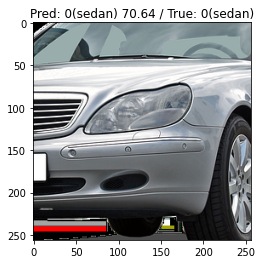

Predicted probability:
[0.900875   0.09912505]


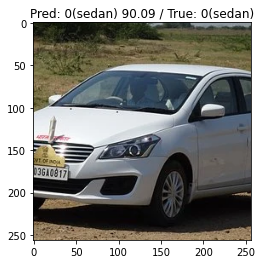

 False predicted images/total sedan category: 0 / 10
Category: truck
 True predicted images/total truck category: 9 / 10
Predicted probability:
[0.39598805 0.60401195]


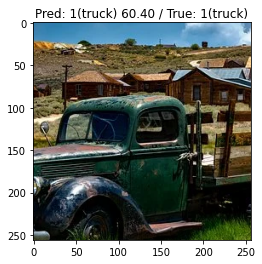

Predicted probability:
[0.33993793 0.6600621 ]


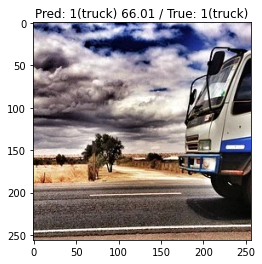

 False predicted images/total truck category: 1 / 10
Predicted probability:
[0.57235265 0.42764735]


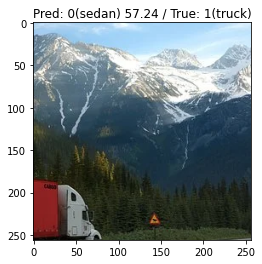

In [110]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)